In [1]:
import os

import cv2
import numpy as np
from matplotlib import pyplot as plt
from skimage.measure import label
from skimage.measure import regionprops
from skimage.morphology import binary_dilation
from skimage.morphology import disk
from skimage.transform import rotate

from src.fish import find_fish_props
from src.models import BoundingBox
from src.models import InputImage
from src.utils import get_bounding_box_obj
from src.utils import normalize_0_255
from src.utils import show_img
from src.well import find_well_props

In [2]:
def plot_images(images, cols: int = None, count: int = None, fig: (int, int) = (16, 16), ticks=False, cmap='binary',
                title=None, hist=False, nums=False):
    if count is not None:
        images = images[0:count]

    l = len(images)

    if l == 0:
        return

    if cols is None:
        cols = 4

    rows = int(l / cols)
    if cols > l > 1: cols = l
    if l % cols != 0 or rows == 0:
        rows += 1

    fig, ax = plt.subplots(rows, cols, figsize=fig)
    ax = ax.ravel()

    for i, img in enumerate(images):
        if i >= l: return

        if nums: ax[i].set_title(f'#{i}')

        if not hist:
            ax[i].imshow(img, cmap)
            if not ticks:  # turn off ticks
                ax[i].get_xaxis().set_visible(False)
                ax[i].get_yaxis().set_visible(False)
        else:
            ax[i].hist(img.ravel(), bins=256)
    fig.suptitle(title, fontsize=56)
    plt.tight_layout()


def plot_fishes(fishes, cols: int = None, count: int = None, fig: (int, int) = (16, 16), ticks=False, cmap='binary',
                title=None, nums=False):
    images = list(map(lambda x: x.processed, fishes))  # Change this!
    plot_images(images, cols, count, fig, ticks, cmap, title, nums)

In [3]:
os.chdir('C:\\Users\\gimes\\source\\repos\\zebra_fishy\\src\\images\\in')
fish_names = os.listdir()
os.chdir('C:\\Users\\gimes\\source\\repos\\zebra_fishy\\src')

fishes = []
successful_fishes = []
bad_names = []
for name in fish_names[::]:
    print(name)
    fishes.append(InputImage(name))
for i, fish in enumerate(fishes):
    print(f'Fish #{i}')
    fish.processed = normalize_0_255(fish.processed)
    fish = find_well_props(fish)
    fish = find_fish_props(fish)
    if fish.success:
        successful_fishes.append(fish)
    else:
        bad_names.append(fish)

fishes = successful_fishes.copy()

zf1.JPG
Reading in file from:
C:\Users\gimes\source\repos\zebra_fishy\src\images\in\zf1.JPG
zf10.jpg
Reading in file from:
C:\Users\gimes\source\repos\zebra_fishy\src\images\in\zf10.jpg
zf11.jpg
Reading in file from:
C:\Users\gimes\source\repos\zebra_fishy\src\images\in\zf11.jpg
zf12.jpg
Reading in file from:
C:\Users\gimes\source\repos\zebra_fishy\src\images\in\zf12.jpg
zf13.jpg
Reading in file from:
C:\Users\gimes\source\repos\zebra_fishy\src\images\in\zf13.jpg
zf14.jpg
Reading in file from:
C:\Users\gimes\source\repos\zebra_fishy\src\images\in\zf14.jpg
zf15.jpg
Reading in file from:
C:\Users\gimes\source\repos\zebra_fishy\src\images\in\zf15.jpg
zf16.jpg
Reading in file from:
C:\Users\gimes\source\repos\zebra_fishy\src\images\in\zf16.jpg
zf17.jpg
Reading in file from:
C:\Users\gimes\source\repos\zebra_fishy\src\images\in\zf17.jpg
zf18.jpg
Reading in file from:
C:\Users\gimes\source\repos\zebra_fishy\src\images\in\zf18.jpg
zf19.jpg
Reading in file from:
C:\Users\gimes\source\repos\zeb

C:\Users\gimes\.miniconda\lib\site-packages\scipy\signal\signaltools.py:1611: RuntimeWarning: divide by zero encountered in true_divide
  res *= (1 - noise / lVar)
C:\Users\gimes\.miniconda\lib\site-packages\scipy\signal\signaltools.py:1611: RuntimeWarning: invalid value encountered in multiply
  res *= (1 - noise / lVar)


# Applying yen-threshold
_____________________________________________________________
# Removing meniscus
_____________________________________________________________
# Keeping only the possible fish
_____________________________________________________________
# Convex hull for mask
_____________________________________________________________
# Bounding box of fish
_____________________________________________________________
# Refining mask
_____________________________________________________________
# Convex hull for mask
_____________________________________________________________
# Bounding box from OG
_____________________________________________________________
IS FISH!
# Getting head of fish
_____________________________________________________________
# Searching for eye regions
_____________________________________________________________
# Removing objects close to the middle of the embryo
_____________________________________________________________
# Found more than 2

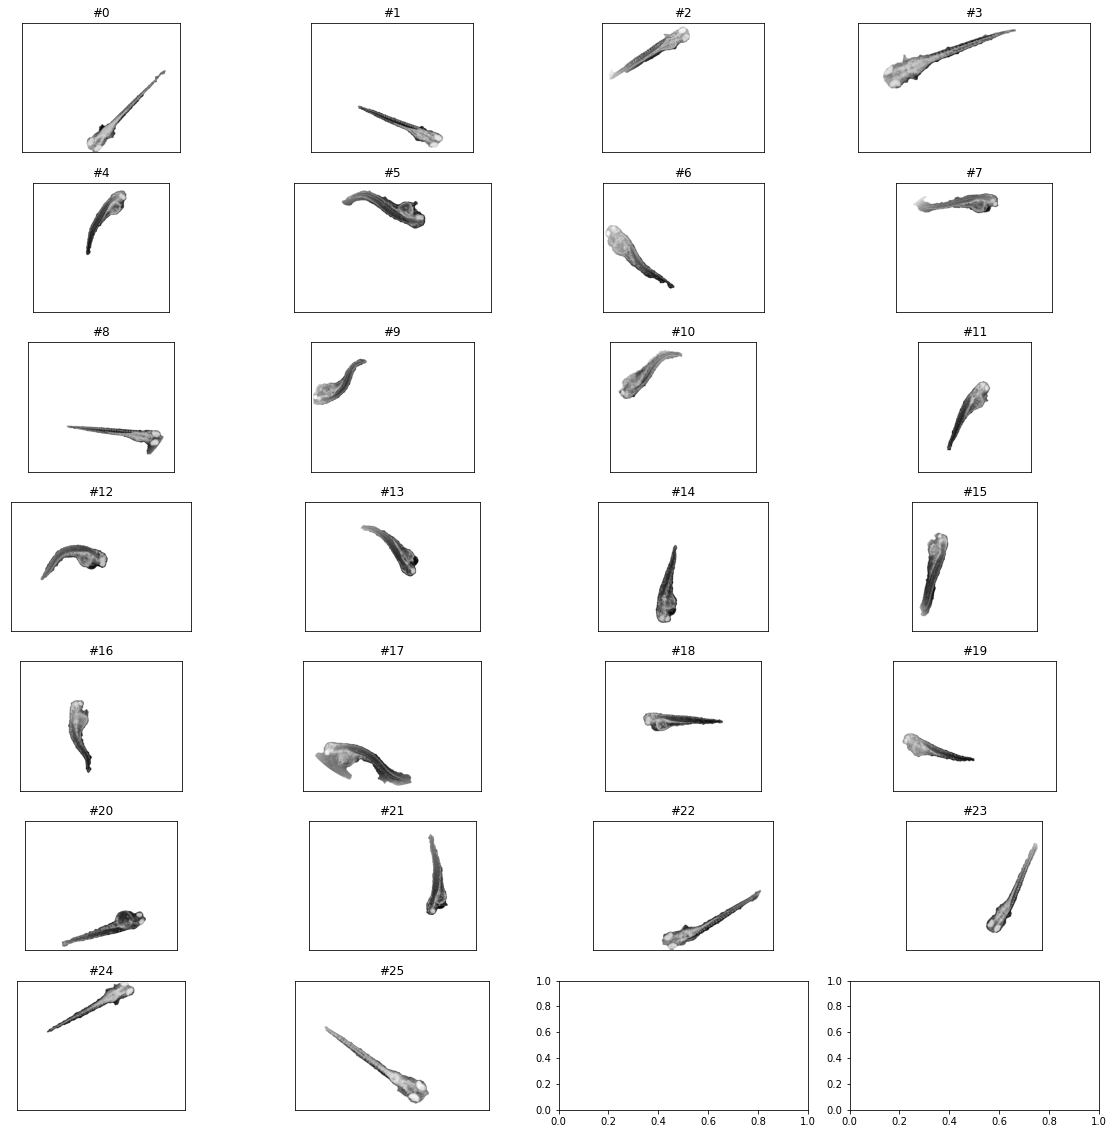

In [4]:
plot_images(list(map(lambda x: (x.fish_props.mask.masked), successful_fishes)), nums=True)

#0
#1
#2
#3
#4
#5
#6
#7
#8
#9
#10
#11
#12
#13
#14
#15
#16
#17
#18
#19
#20
#21
#22
#23
#24
#25


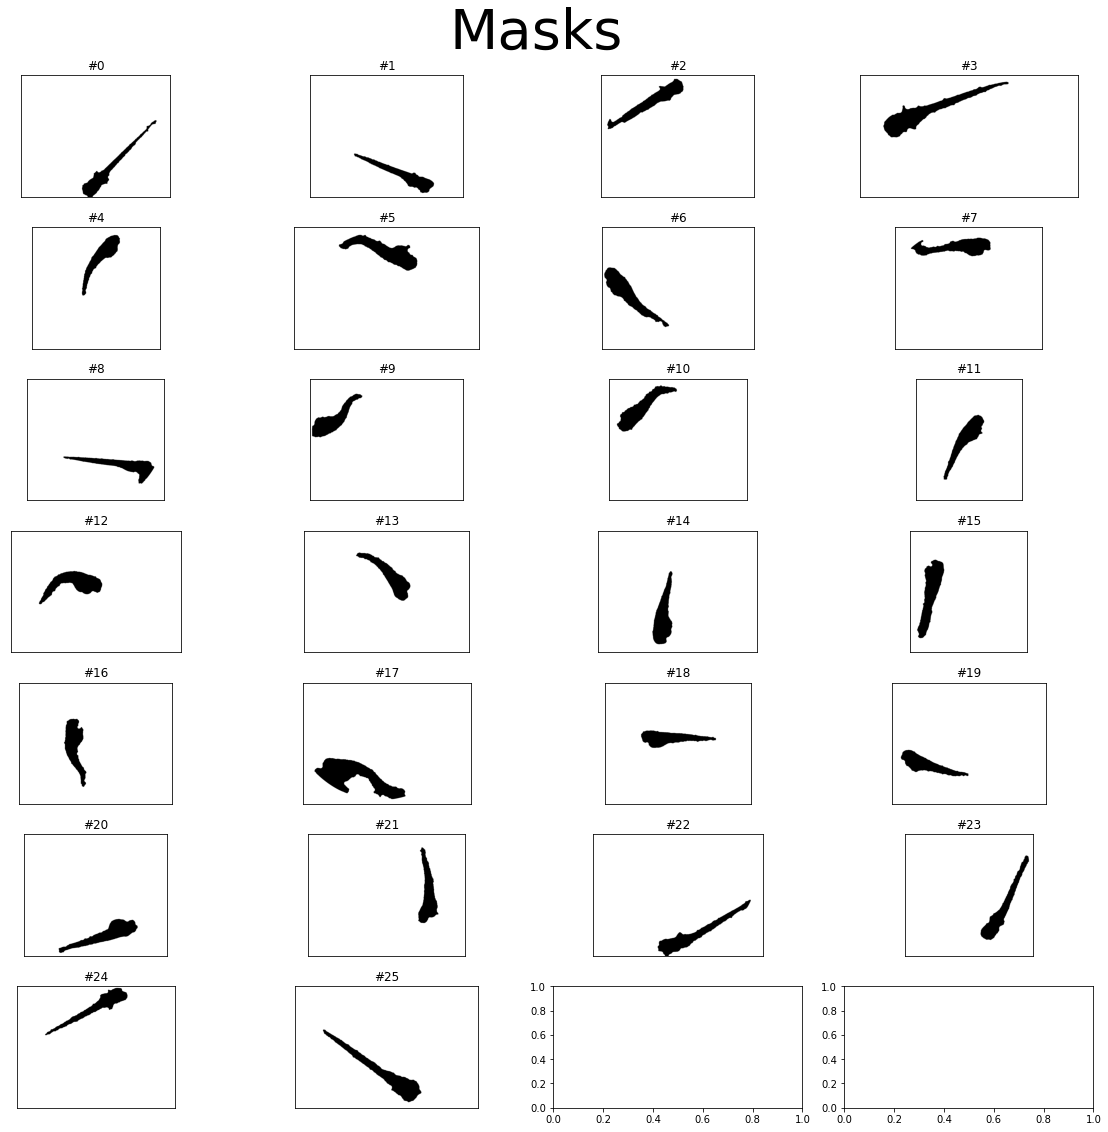

In [5]:
masks = []

for i, fish in enumerate(fishes):
    print(f'#{i}')
    if fish.fish_props.has_fish: masks.append(fish.fish_props.mask.og)
plot_images(masks, nums=True, title="Masks")

#0
has eyes
#1
has eyes
#2
has eyes
#3
has eyes
#4
has eyes
#5
has eyes
#6
has eyes
#7
has eyes
#8
has eyes
#9
has eyes
#10
has eyes
#11
has eyes
#12
has eyes
#13
has eyes
#14
has eyes
#15
has eyes
#16
has eyes
#17
has eyes
#18
has eyes
#19
has eyes
#20
has eyes
#21
has eyes
#22
has eyes
#23
has eyes
#24
has eyes
#25
has eyes


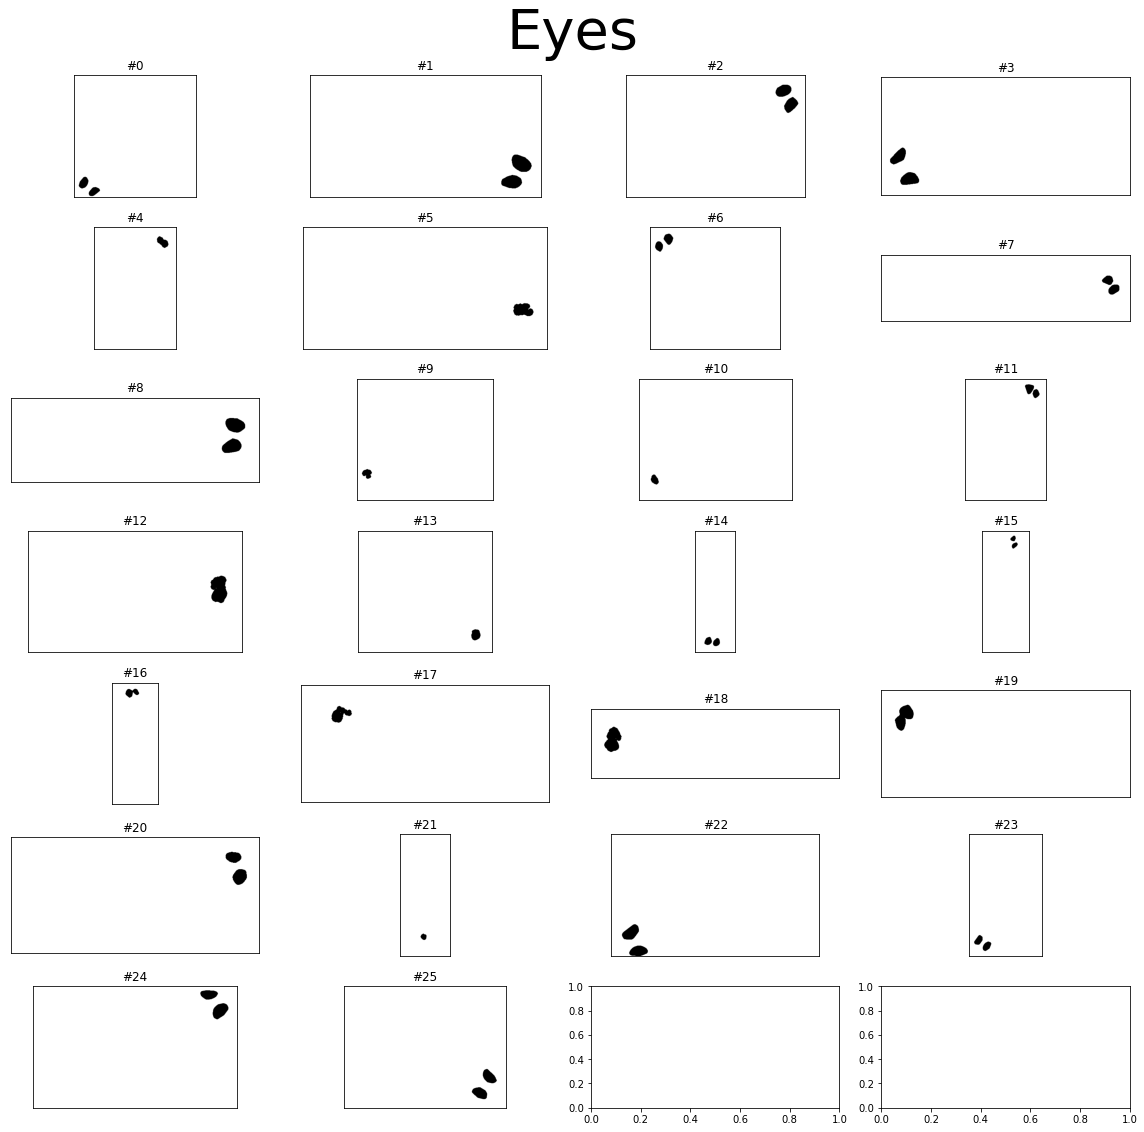

In [6]:
eyes = []

for i, fish in enumerate(successful_fishes):
    print(f'#{i}')
    if fish.fish_props.has_eyes:
        print('has eyes')
        eyes.append(fish.fish_props.eyes)
    else:
        print('has no eyes')

plot_images(eyes, nums=True, title="Eyes")

#0
#1
#2
#3
#4
#5
#6
#7
#8
#9
#10
#11
#12
#13
#14
#15
#16
#17
#18
#19
#20
#21
#22
#23
#24
#25


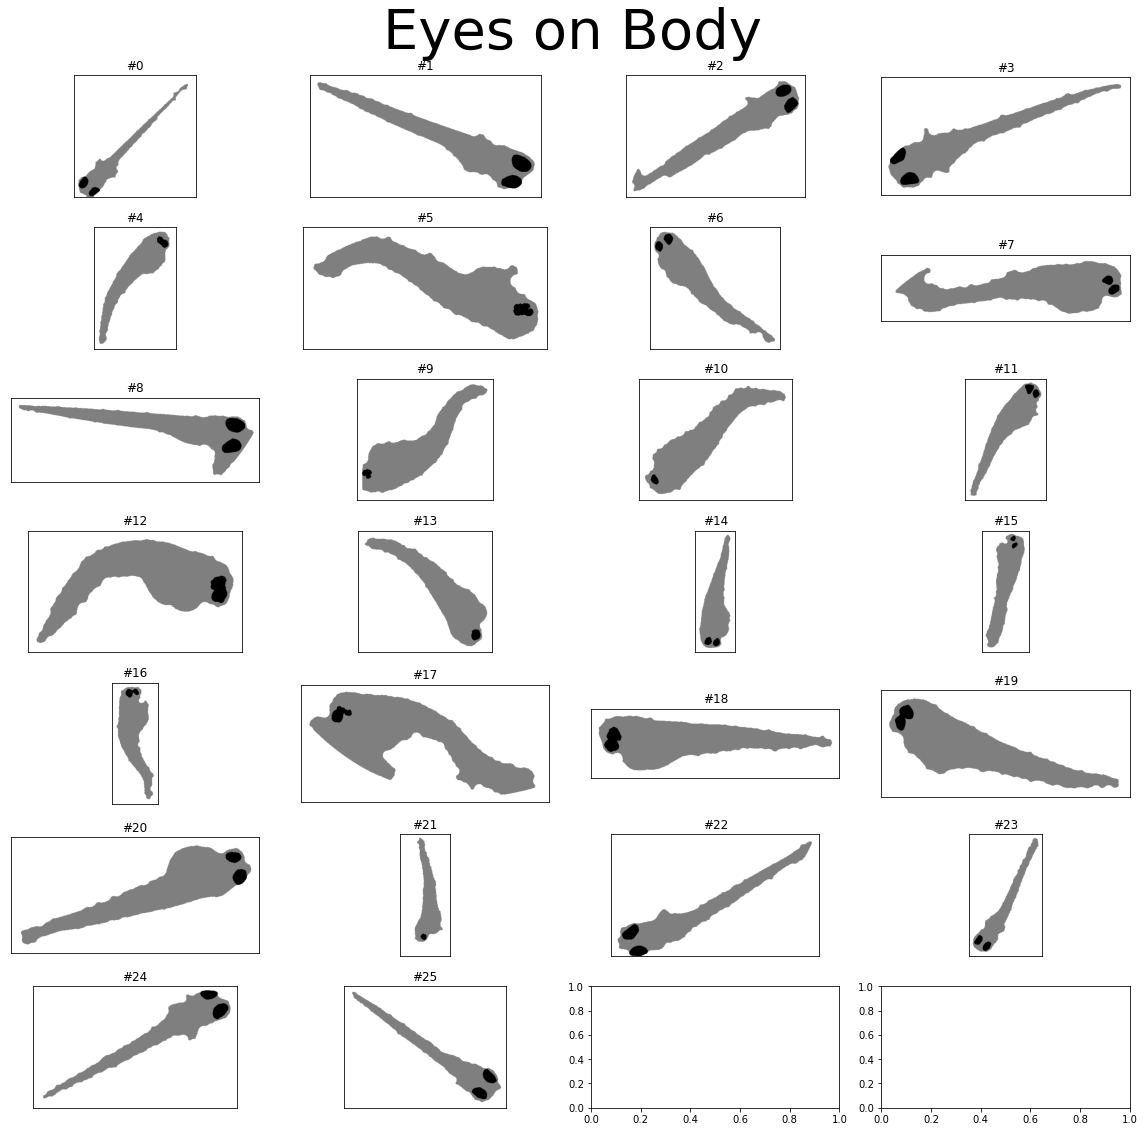

In [7]:
eyes_on_body = []

for i, fish in enumerate(successful_fishes[::]):
    print(f"#{i}")
    if fish.fish_props.has_eyes:
        eyes_on_body.append((fish.fish_props.mask.cropped.astype(float) + fish.fish_props.eyes.astype(float)))
plot_images(eyes_on_body, nums=True, title="Eyes on Body")

In [16]:
def align_to_x_axis(img: np.ndarray):
    props = regionprops(label(img))
    angle_in_degrees = props[0].orientation * (180 / np.pi) + 90
    return rotate(img, -angle_in_degrees, resize=True, center=props[0].centroid)


def rotate_back(img: np.ndarray, desired_orientation: float, center=(0, 0)):
    angle_in_degrees = desired_orientation * (180 / np.pi) + 90
    return rotate(img, angle_in_degrees, resize=True, center=center)

# Visualize axes ratio

In [56]:
import math


def draw_axes(img):
    fig, ax = plt.subplots()
    label_img = label(img)
    regions = regionprops(label_img)
    ax.imshow(img, 'gray')
    props = regions[0]

    y0, x0 = props.centroid

    bbox = BoundingBox()
    bbox.set(props.bbox)

    x0 = (bbox.y2 - bbox.y1) / 2
    y0 = (bbox.x2 - bbox.x1) / 2

    orientation = props.orientation
    x1 = x0 + math.cos(orientation) * 0.5 * props.axis_minor_length
    y1 = y0 - math.sin(orientation) * 0.5 * props.axis_minor_length

    x2 = x0 - math.sin(orientation) * 0.5 * props.axis_major_length
    y2 = y0 - math.cos(orientation) * 0.5 * props.axis_major_length

    x3 = x0 + math.sin(orientation) * 0.5 * props.axis_major_length
    y3 = y0 + math.cos(orientation) * 0.5 * props.axis_major_length

    x4 = x0 - math.cos(orientation) * 0.5 * props.axis_minor_length
    y4 = y0 + math.sin(orientation) * 0.5 * props.axis_minor_length

    ax.plot((x0, x1), (y0, y1), '-b', linewidth=2.5)
    ax.plot((x0, x3), (y0, y3), '-r', linewidth=2.5)
    ax.plot((x0, x2), (y0, y2), '-r', linewidth=2.5)
    ax.plot((x0, x4), (y0, y4), '-b', linewidth=2.5)
    ax.plot(x0, y0, '.g', markersize=5)

    minr, minc, maxr, maxc = props.bbox
    bx = (minc, maxc, maxc, minc, minc)
    by = (minr, minr, maxr, maxr, minr)
    #ax.plot(bx, by, '-y', linewidth=2.5)

    return props.axis_major_length / props.axis_minor_length

In [57]:
def crop_to_bbox(img):
    props = regionprops(label(img))[0]
    bbox = BoundingBox()
    bbox.set(props.bbox)
    return bbox.bound_img(img)

4.615763077548624

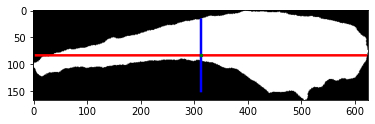

In [68]:
draw_axes(a[11])

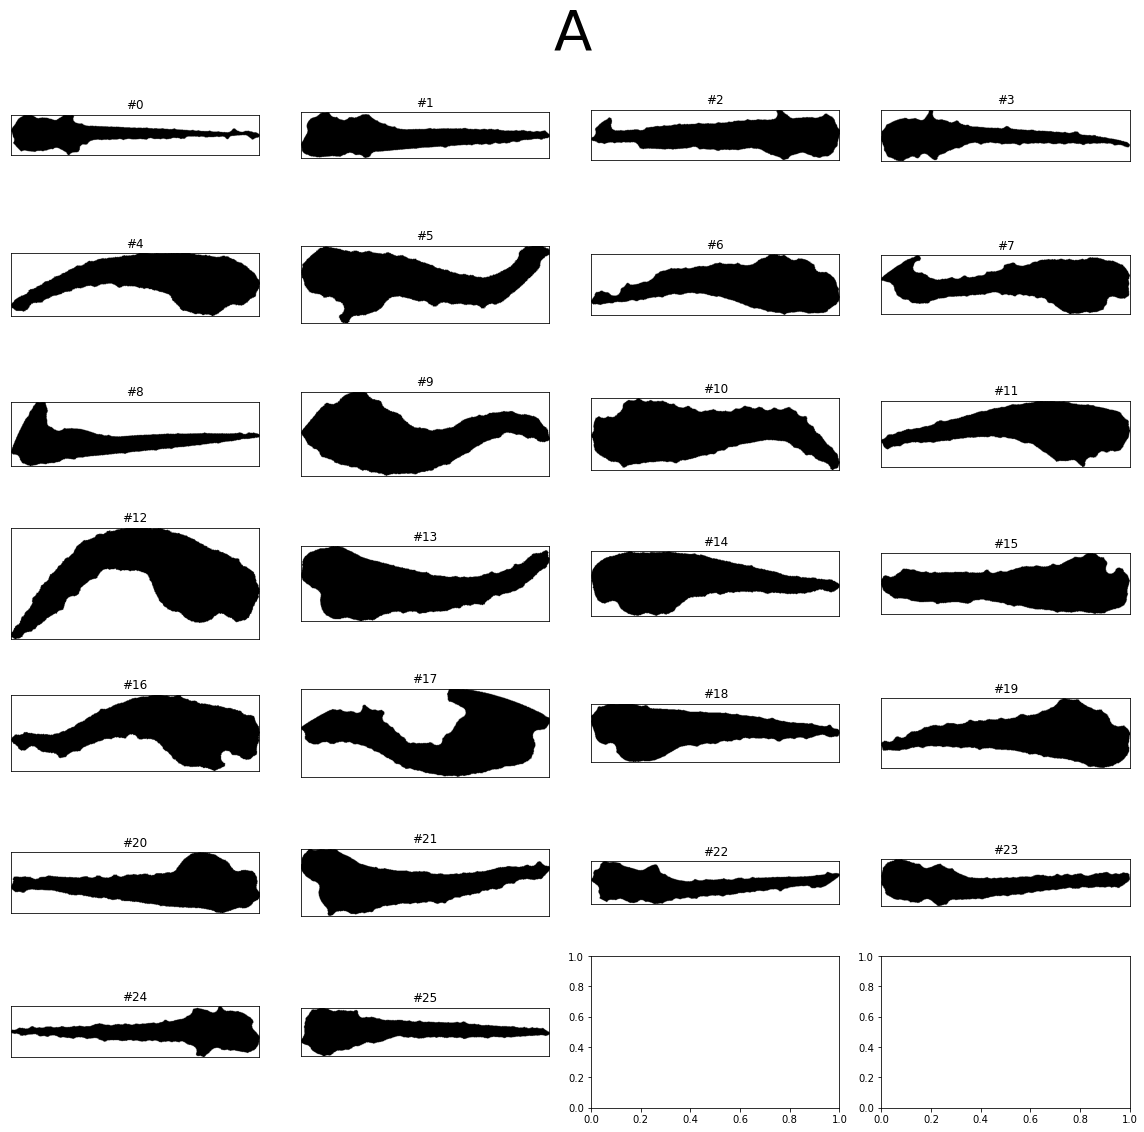

In [51]:
a = []

for i, mask in enumerate(masks):
    a.append(crop_to_bbox(align_to_x_axis((mask))))

plot_images(a, nums=True, title='A')

_____________

In [ ]:
def get_endpoints_of_skeleton(skeleton: np.ndarray) -> np.ndarray:
    kernel = np.asarray([
        [-1, -1, -1],
        [-1, 2, -1],
        [-1, -1, -1]
    ])
    skeleton = normalize_0_255(skeleton.astype(float)).astype(np.uint8)
    return cv2.filter2D(skeleton, -1, kernel).astype(bool)


In [ ]:
fish = re_[19]
print(fish.shape)

kernel = np.asarray([
    [-1, -1, -1],
    [-1, 2, -1],
    [-1, -1, -1]
])

fish = normalize_0_255(fish.astype(float)).astype(np.uint8)
filtered = cv2.filter2D(fish, -1, kernel).astype(bool)
plt.imshow(binary_dilation(filtered, disk(1)), 'binary')

print(filtered.nonzero())

In [ ]:
fish = successful_fishes[1]
props = regionprops(label(fish.fish_props.mask.cropped))

plt.imshow(fish.fish_props.mask.cropped, 'gray')
plt.xticks([])
plt.yticks([])

In [ ]:



def get_eps(img: np.ndarray):
    og_shape = img.shape
    bbox = get_bounding_box_obj(img)  # bbox to og image
    cropped_img = bbox.bound_img(img)  # crop to bbox

    props = regionprops(label(img))

    rotated = align_to_x_axis(cropped_img, props[0].orientation, props[0].centroid)
    bbox_rot = get_bounding_box_obj(rotated)  # bbox to og image
    rotated = bbox_rot.bound_img(rotated)
    eps = get_limits_of_object(rotated)
    np.zeros_like

    rotated_back = rotate_back(eps, props[0].orientation, props[0].centroid)
    bbox_rot = get_bounding_box_obj(rotated_back)  # bbox to og image
    rotated_back = bbox_rot.bound_img(rotated_back)

    print(rotated.dtype)
    return [cropped_img, rotated, eps, rotated_back]


In [ ]:
plot_images(get_eps(fish.fish_props.mask.cropped))

In [ ]:
def crop_to_bbox(img):
    props = regionprops(label(img))[0]
    bbox = BoundingBox()
    bbox.set(props.bbox)
    return bbox.bound_img(img)


def get_length(img):
    a = crop_to_bbox(img)
    props = regionprops(label(img))[0]
    centroid = props.centroid
    orientation = props.orientation
    show_img(a, 'a')

    a = crop_to_bbox(align_to_x_axis(a, orientation, centroid))
    b = limits_marked(a)
    show_img(b, 'b')

    props = regionprops(label(img))[0]
    new_centroid = props.centroid

    c = crop_to_bbox(rotate_back(a, orientation, new_centroid))
    print(c.shape)
    show_img(c, 'c')


get_length(masks[0])

In [ ]:
from skimage.color import gray2rgb
from src.measure import get_limits_of_object


def limits_marked(image: np.ndarray) -> np.ndarray:
    img = image.astype(float)
    img = gray2rgb(img)

    print(get_limits_of_object(img))

    left_max, right_max, top_max, bottom_max = get_limits_of_object(img)

    cv2.circle(img, top_max, 1, (0, 255, 0), 10)
    cv2.circle(img, bottom_max, 1, (0, 255, 0), 10)
    cv2.circle(img, right_max, 1, (255, 0, 0), 10)
    cv2.circle(img, left_max, 1, (255, 0, 0), 10)
    cv2.line(img, left_max, right_max, (0, 0, 255), 3)

    return img

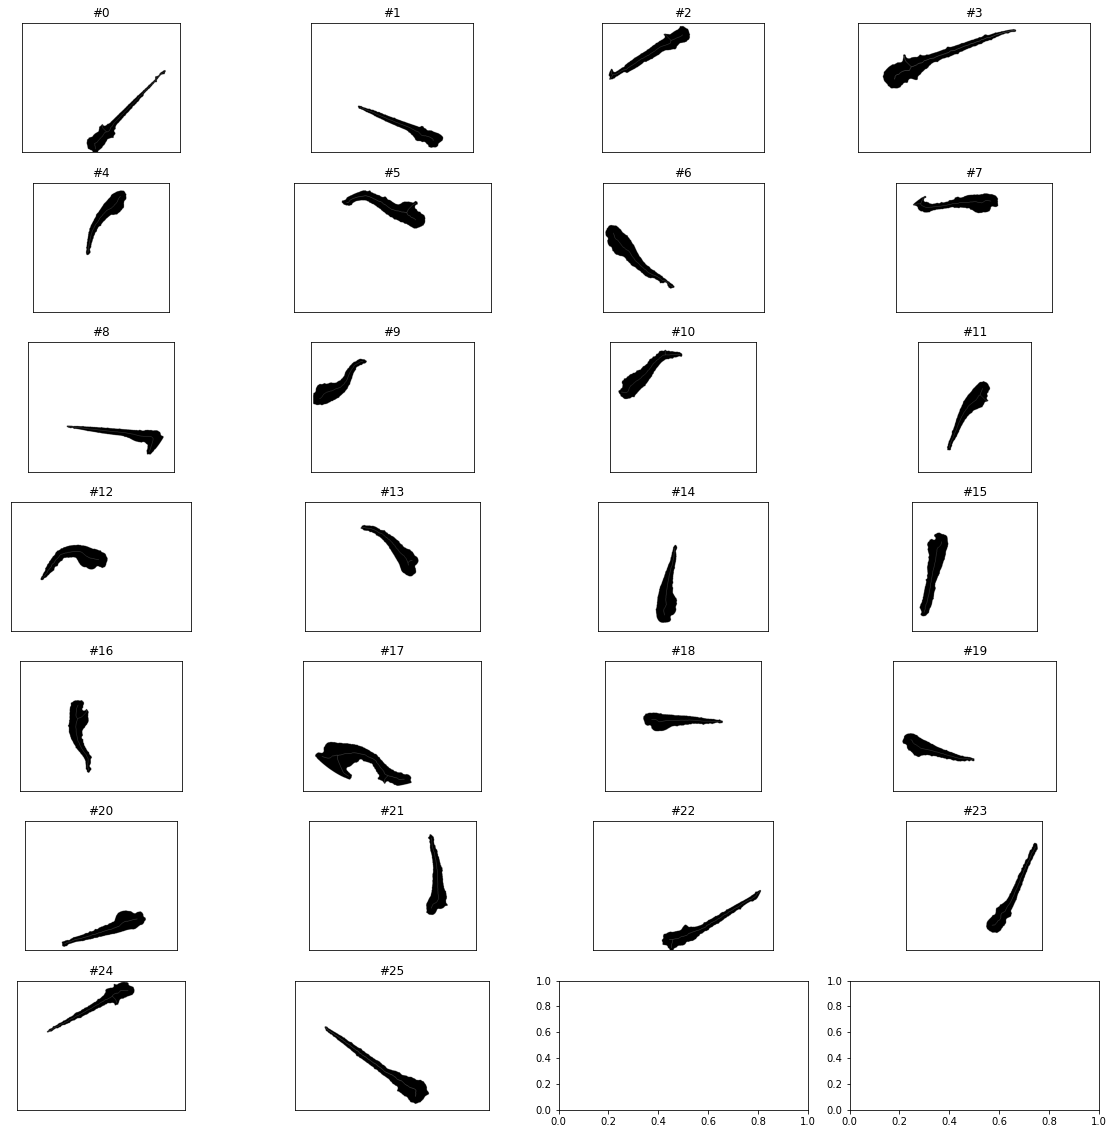

In [55]:
from skimage.morphology import skeletonize

#plot_images(rotated_back, nums=True)
skel = []
for i, rotated in enumerate(masks):
    skel.append(np.logical_xor(skeletonize(rotated, method='lee'), masks[i]))

plot_images(skel, nums=True)